##**In class Exercise 4**

(1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Write your code here
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import spacy.cli
spacy.cli.download('en_core_web_sm')
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
name = [ ]
data = [ ]
page_number = [0,10,20,30,40,50,60,70,80,90]
for i in page_number:
  page = requests.get('https://www.imdb.com/title/tt13131798/reviews/?ref_=tt_ql_urv'+ str (i))
  soup = BeautifulSoup(page.content,'html.parser')
  name.append(soup.find_all('a',class_="title"))

for j in name:
  for k in range(len(j)):
    data.append(j[k].get_text())
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[data_words[0]]])

['sharwanand', 'completely', 'forgot', 'on', 'how', 'to', 'choose', 'scripts']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['completely', 'forget', 'choose', 'script']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)


texts = data_lemmatized


corpus = [id2word.doc2bow(text) for text in texts]


print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.471*"notion" + 0.471*"misfired" + 0.002*"movie" + 0.002*"boring" + '
  '0.002*"average" + 0.002*"completely" + 0.002*"choose" + 0.002*"forget" + '
  '0.002*"script" + 0.002*"bad"'),
 (1,
  '0.037*"second" + 0.037*"better" + 0.037*"could" + 0.037*"half" + '
  '0.037*"emotion" + 0.037*"story" + 0.037*"end" + 0.037*"movie" + '
  '0.037*"casting" + 0.037*"love"'),
 (2,
  '0.037*"society" + 0.037*"show" + 0.037*"s" + 0.037*"happen" + '
  '0.037*"misfired" + 0.037*"story" + 0.037*"good" + 0.037*"casting" + '
  '0.037*"bad" + 0.037*"average"'),
 (3,
  '0.037*"average" + 0.037*"choose" + 0.037*"bad" + 0.037*"completely" + '
  '0.037*"good" + 0.037*"story" + 0.037*"casting" + 0.037*"forget" + '
  '0.037*"script" + 0.037*"show"'),
 (4,
  '0.243*"story" + 0.243*"bad" + 0.243*"good" + 0.243*"casting" + '
  '0.001*"completely" + 0.001*"choose" + 0.001*"script" + 0.001*"forget" + '
  '0.001*"movie" + 0.001*"boring"'),
 (5,
  '0.242*"second" + 0.242*"better" + 0.242*"could" + 0.242*"half" +

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -2.8610436991337806

Coherence Score:  0.669933613161464


In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

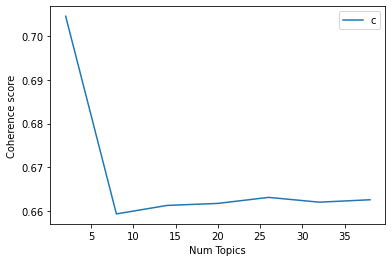

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7045
Num Topics = 8  has Coherence Value of 0.6593
Num Topics = 14  has Coherence Value of 0.6613
Num Topics = 20  has Coherence Value of 0.6617
Num Topics = 26  has Coherence Value of 0.6631
Num Topics = 32  has Coherence Value of 0.662
Num Topics = 38  has Coherence Value of 0.6626


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.667*"end" + 0.333*"society" + 0.000*"emotion" + 0.000*"casting" + '
  '0.000*"good" + 0.000*"story" + 0.000*"average" + 0.000*"movie" + '
  '0.000*"show" + 0.000*"s"'),
 (1,
  '1.000*"casting" + 0.000*"movie" + 0.000*"emotion" + 0.000*"good" + '
  '0.000*"story" + 0.000*"end" + 0.000*"average" + 0.000*"show" + '
  '0.000*"happen" + 0.000*"notion"'),
 (2,
  '0.462*"average" + 0.385*"misfired" + 0.154*"script" + 0.000*"movie" + '
  '0.000*"good" + 0.000*"story" + 0.000*"end" + 0.000*"love" + 0.000*"show" + '
  '0.000*"happen"'),
 (3,
  '1.000*"happen" + 0.000*"end" + 0.000*"emotion" + 0.000*"casting" + '
  '0.000*"good" + 0.000*"story" + 0.000*"average" + 0.000*"movie" + '
  '0.000*"show" + 0.000*"s"'),
 (4,
  '0.588*"choose" + 0.412*"script" + 0.000*"movie" + 0.000*"love" + '
  '0.000*"good" + 0.000*"story" + 0.000*"end" + 0.000*"bad" + 0.000*"show" + '
  '0.000*"s"'),
 (5,
  '0.556*"completely" + 0.444*"forget" + 0.000*"movie" + 0.000*"casting" + '
  '0.000*"good" + 0.000*"st

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.0813,"completely, forget, movie, casting, good, stor...",Sharwanand Completely forgot on how to choose...
1,1,7.0,0.0621,"half, average, misfired, end, emotion, good, s...",Second half could have been better
2,2,17.0,0.0686,"boring, half, good, story, end, movie, bad, em...",Boring
3,3,8.0,0.0865,"watch, mahasamudram, end, emotion, good, story...",mahasamudram is a must watch
4,4,10.0,0.0673,"notion, bad, casting, good, story, end, averag...",Misfired Notion
5,5,19.0,0.0621,"average, misfired, bad, story, end, show, cast...",Below average👎
6,6,13.0,0.0689,"good, bad, forget, misfired, movie, story, end...",Good story but bad casting
7,7,14.0,0.0621,"bad, movie, casting, good, story, end, average...",Not too bad
8,8,0.0,0.0664,"end, society, emotion, casting, good, story, a...",Till the end
9,9,0.0,0.0500,"end, society, emotion, casting, good, story, a...",Maha soonyam


In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

  
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)


sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0686,"end, society, emotion, casting, good, story, a...",Till the end
1,1.0,0.0669,"casting, movie, emotion, good, story, end, ave...",Good story but bad casting
2,2.0,0.0577,"average, misfired, script, movie, good, story,...",Below average👎
3,3.0,0.0660,"happen, end, emotion, casting, good, story, av...",Showing something thats happening in society..
4,4.0,0.0813,"choose, script, movie, love, good, story, end,...",Sharwanand Completely forgot on how to choose...


In [ ]:

topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()


topic_contribution = round(topic_counts/topic_counts.sum(), 4)


topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]


df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)


df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']


df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"completely, forget, movie, casting, good, stor...",20.0,0.1429
1.0,7.0,"half, average, misfired, end, emotion, good, s...",6.0,0.0429
2.0,17.0,"boring, half, good, story, end, movie, bad, em...",5.0,0.0357
3.0,8.0,"watch, mahasamudram, end, emotion, good, story...",1.0,0.0071
4.0,10.0,"notion, bad, casting, good, story, end, averag...",2.0,0.0143
...,...,...,...,...
135.0,0.0,"end, society, emotion, casting, good, story, a...",NaN,NaN
136.0,16.0,"movie, society, emotion, casting, good, story,...",NaN,NaN
137.0,16.0,"movie, society, emotion, casting, good, story,...",NaN,NaN
138.0,6.0,"love, forget, movie, good, story, end, bad, em...",NaN,NaN


## **(2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:**

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
# Write your code here

import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


In [ ]:
def preprocess_data(doc_set):
    
    tokenizer = RegexpTokenizer(r'\w+')
    
    en_stop = set(stopwords.words('english'))
    
    p_stemmer = PorterStemmer()
    
    texts = []
    
    for i in doc_set:
        
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        
        stopped_tokens = [i for i in tokens if not i in en_stop]
        
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)

[['sharwanand', 'complet', 'forgot', 'choos', 'script'],
 ['second', 'half', 'could', 'better'],
 ['bore'],
 ['mahasamudram', 'must', 'watch'],
 ['misfir', 'notion'],
 ['averag'],
 ['good', 'stori', 'bad', 'cast'],
 ['bad'],
 ['till', 'end'],
 ['maha', 'soonyam'],
 ['averag', 'movi'],
 ['super', 'movi'],
 ['love', 'emot', 'movi'],
 ['show', 'someth', 'that', 'happen', 'societi'],
 ['sharwanand', 'complet', 'forgot', 'choos', 'script'],
 ['second', 'half', 'could', 'better'],
 ['bore'],
 ['mahasamudram', 'must', 'watch'],
 ['misfir', 'notion'],
 ['averag'],
 ['good', 'stori', 'bad', 'cast'],
 ['bad'],
 ['till', 'end'],
 ['maha', 'soonyam'],
 ['averag', 'movi'],
 ['super', 'movi'],
 ['love', 'emot', 'movi'],
 ['show', 'someth', 'that', 'happen', 'societi'],
 ['sharwanand', 'complet', 'forgot', 'choos', 'script'],
 ['second', 'half', 'could', 'better'],
 ['bore'],
 ['mahasamudram', 'must', 'watch'],
 ['misfir', 'notion'],
 ['averag'],
 ['good', 'stori', 'bad', 'cast'],
 ['bad'],
 ['till',

In [ ]:
def prepare_corpus(doc_clean):
    
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary,doc_term_matrix

In [ ]:
number_of_topics=7
words=10

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

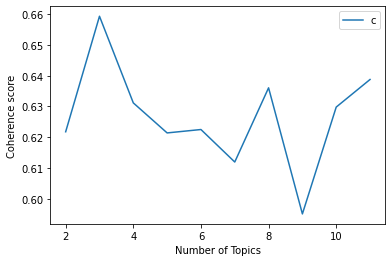

In [ ]:
start,stop,step=2,12,1
plot_graph(preprocess_data(data),start,stop,step)

In [ ]:
model=create_gensim_lsa_model(preprocess_data(data),number_of_topics,words)

[(0, '0.425*"happen" + 0.425*"that" + 0.425*"someth" + 0.425*"societi" + 0.425*"show" + 0.139*"script" + 0.139*"choos" + 0.139*"forgot" + 0.139*"complet" + 0.139*"sharwanand"'), (1, '0.425*"forgot" + 0.425*"complet" + 0.425*"choos" + 0.425*"sharwanand" + 0.425*"script" + -0.139*"societi" + -0.139*"that" + -0.139*"someth" + -0.139*"happen" + -0.139*"show"'), (2, '0.799*"movi" + 0.321*"averag" + 0.321*"love" + 0.321*"emot" + 0.229*"super" + -0.000*"happen" + -0.000*"someth" + -0.000*"societi" + -0.000*"show" + -0.000*"that"'), (3, '0.601*"bad" + 0.461*"good" + 0.461*"stori" + 0.461*"cast" + -0.000*"movi" + -0.000*"averag" + 0.000*"forgot" + -0.000*"love" + -0.000*"emot" + 0.000*"script"'), (4, '0.500*"half" + 0.500*"second" + 0.500*"could" + 0.500*"better" + -0.000*"bad" + -0.000*"cast" + -0.000*"stori" + -0.000*"good" + 0.000*"mahasamudram" + 0.000*"watch"'), (5, '-0.577*"watch" + -0.577*"must" + -0.577*"mahasamudram" + -0.000*"movi" + 0.000*"half" + -0.000*"love" + -0.000*"emot" + 0.00

**(3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.**

Topic Modeling may be tested using the notion of Topic Coherence. A variety of methods are used to obtain topic models. The two methodologies are Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA). The LDA (Leadership Development Agency) is a non-profit organization that promotes leadership development.

The LDA subject model relies on two major inputs: a dictionary and a corpus. Gensim assigns a unique id to each word in the document. In addition to the corpus and dictionary, we must also consider the amount of subjects.



We may use the LDA visualization tool pyLDAvis to experiment with a small number of themes and compare the results.



Topic coherence is one of the most widely used methods for estimating the number of topics.